# Final Project — Medical Tabular Classification (Brain Tumor + Breast Cancer)

**Author:** Leonardo Machado  
**Course:** Stanford Continuing Studies — Applied ML with Python  
**Date:** 2025-08-29

1. Project Title, Problem Statement, Objectives & Goals  
2. Methodology & Block Diagram (pipeline)  
3. Datasets (Brain Tumor)  
4. Data Visualization & Feature Engineering notes  
5. 8 Algorithms:
  5.1) LogReg,
  5.2) SVM-linear
  5.3) SVM-RBF
  5.4) kNN
  5.5) DecisionTree
  5.6) RandomForest
  5.6) GradientBoosting
  5.7) MLP
6. Experiments, Metrics, Comparison Tables/Graphs  
7. Optimization & Test Results
8. Standards/Constraints, Bias/Ethics, Limitations, Conclusion & Future Work


## 0) Setup
Reproducibility, imports, and utility functions.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score, recall_score,
                             precision_score, confusion_matrix, classification_report,
                             RocCurveDisplay, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.datasets import load_breast_cancer
import os

#Garantee reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

#Setting matplotlib styling
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.6
plt.rcParams['grid.linestyle'] = '--'

## 1) Project framing
**Problem Statement:** Tumor detection from image-derived tabular features to support triage.

**Objectives & Goals:**
- Train **8 algorithms** (mix of classical ML + shallow DL).
- Prioritize **Recall (tumor class)** and **ROC-AUC**; include interpretability (coefficients/feature importances).

**Methodology / Pipeline:** Preprocess data → Split (test/validation data) → Pipeline(Scaler→Model) → CV + GridSearch → Test → Plots → Analysis.


## 2) Load Datasets
We use your Brain Tumor CSV and a comparator dataset (Breast Cancer Wisconsin) from scikit-learn.

**Instructions for Colab:**
1. Upload `Brain Tumor.csv` to Colab root (`/content`).
2. If not uploaded, run the upload cell below.

In [2]:
from google.colab import files
#If the file is not already uploaded, upload the dataset
if not os.path.exists('/content/Brain Tumor.csv'):
    print('Upload Brain Tumor.csv...')
    #Upload file
    uploaded = files.upload()

Upload Brain Tumor.csv...


Saving Brain Tumor.csv to Brain Tumor.csv


In [3]:
#Define dataset path
bt_path = '/content/Brain Tumor.csv'
#Read dataset into bt variable
bt = pd.read_csv(bt_path)

# Features: drop non-feature column 'Image' and keep 'Class' as target if present
X_bt = bt.drop(columns=[c for c in ['Image','Class'] if c in bt.columns])
y_bt = bt['Class'].astype(int)

# Comparator dataset
bc = load_breast_cancer()
X_bc = pd.DataFrame(bc.data, columns=bc.feature_names)
y_bc = pd.Series(bc.target, name='Class')

print('Brain Tumor shape:', X_bt.shape, ' target n:', y_bt.shape)
print('Breast Cancer shape:', X_bc.shape, ' target n:', y_bc.shape)

# Class balance quick look
print('\nBrain Tumor class counts:\n', y_bt.value_counts())
print('\nBreast Cancer class counts:\n', y_bc.value_counts())

Brain Tumor shape: (3762, 13)  target n: (3762,)
Breast Cancer shape: (569, 30)  target n: (569,)

Brain Tumor class counts:
 Class
0    2079
1    1683
Name: count, dtype: int64

Breast Cancer class counts:
 Class
1    357
0    212
Name: count, dtype: int64


## 2.1) Dataset overview

In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.feature_selection import mutual_info_classif

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.4
plt.rcParams["grid.linestyle"] = "--"

def savefig(name):
    plt.tight_layout()
    plt.savefig(name, dpi=300, bbox_inches="tight")
    plt.show()

def top_features_by_variance(X, k=6):
    v = X.var().sort_values(ascending=False)
    return list(v.head(k).index)

def top_features_by_mi(X, y, k=6):
    # Safe MI even if some cols constant
    X_ = X.select_dtypes(include=[np.number]).fillna(0.0)
    mi = mutual_info_classif(X_, y, discrete_features=False, random_state=42)
    mi = pd.Series(mi, index=X_.columns).sort_values(ascending=False)
    return list(mi.head(k).index)


# 2.1.1) Brain Tumor

,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness,Class
0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155,0
1,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155,0
2,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155,1
3,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155,1
4,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155,0
5,7.524109,607.395258,24.645390,0.214086,3.729886,14.471736,105.077882,0.421587,0.177736,0.598169,4.193146,0.976485,7.458341e-155,0
6,12.304413,922.746138,30.376737,0.128833,2.930095,8.969348,115.203118,0.320675,0.102832,0.532292,4.880320,0.974745,7.458341e-155,0
7,15.929474,1069.950248,32.710094,0.107658,2.484002,6.515889,94.874288,0.291321,0.084868,0.532262,4.242054,0.976774,7.458341e-155,0
8,19.921616,1166.120922,34.148513,0.094975,2.129173,4.905844,93.818920,0.272486,0.074248,0.526644,4.027167,0.974310,7.458341e-155,0
9,8.476196,1095.785127,33.102645,0.003002,4.365000,19.682514,72.588783,0.045685,0.002087,0.361432,4.590795,0.967830,7.458341e-155,1


,count,mean,std,min,25%,50%,75%,max
Mean,3762.0,9.488890e+00,5.728022,7.865906e-02,4.982395e+00,8.477531e+00,1.321272e+01,3.323997e+01
Variance,3762.0,7.111011e+02,467.466896,3.145628e+00,3.632255e+02,6.225804e+02,9.669543e+02,2.910582e+03
Standard Deviation,3762.0,2.518227e+01,8.773526,1.773592e+00,1.905847e+01,2.495156e+01,3.109589e+01,5.394981e+01
Entropy,3762.0,7.360262e-02,0.070269,8.815796e-04,6.856456e-03,6.662805e-02,1.132844e-01,3.945386e-01
Skewness,3762.0,4.102727e+00,2.560940,1.886014e+00,2.620203e+00,3.422210e+00,4.651737e+00,3.693129e+01
Kurtosis,3762.0,2.438907e+01,56.434747,3.942402e+00,7.252852e+00,1.235909e+01,2.264030e+01,1.371640e+03
Contrast,3762.0,1.279615e+02,109.499601,3.194733e+00,7.212521e+01,1.067374e+02,1.610590e+02,3.382574e+03
Energy,3762.0,2.047051e-01,0.129352,2.473117e-02,6.961745e-02,2.254965e-01,2.989014e-01,5.896818e-01
ASM,3762.0,5.863159e-02,0.058300,6.116308e-04,4.846590e-03,5.084867e-02,8.934206e-02,3.477246e-01
Homogeneity,3762.0,4.792519e-01,0.127929,1.054898e-01,3.649727e-01,5.125512e-01,5.755566e-01,8.109208e-01


Dtype counts:
 float64    13
int64       1
Name: count, dtype: int64 



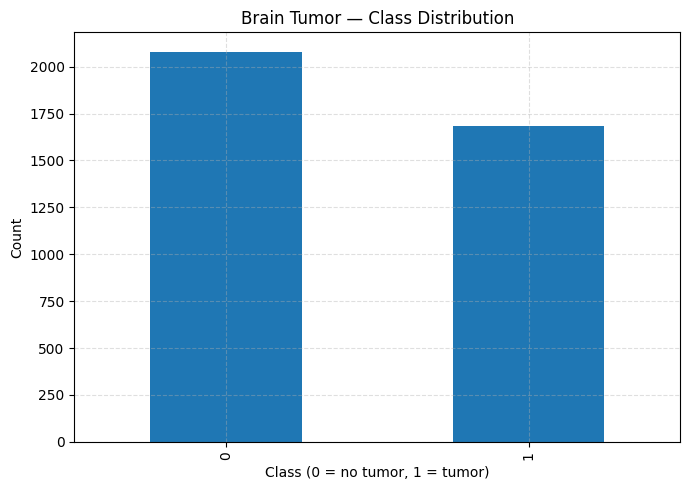

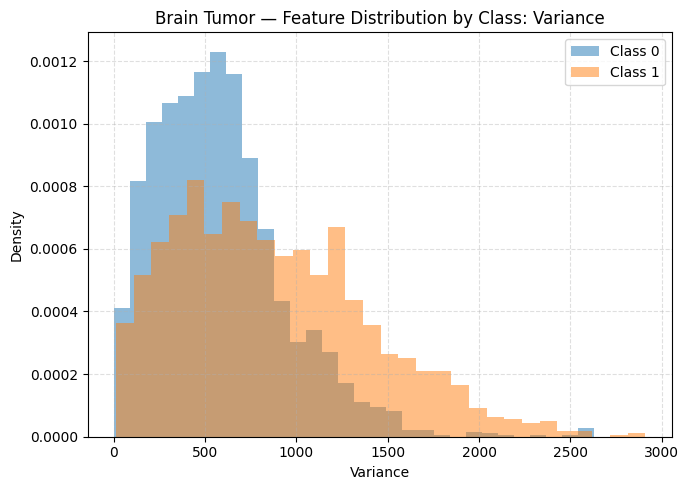

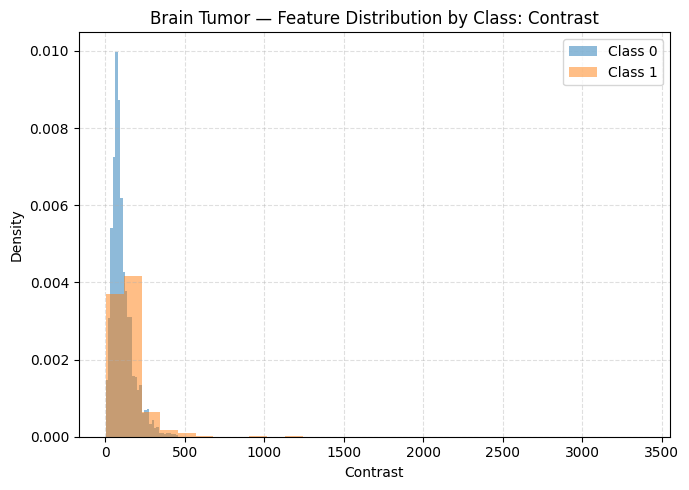

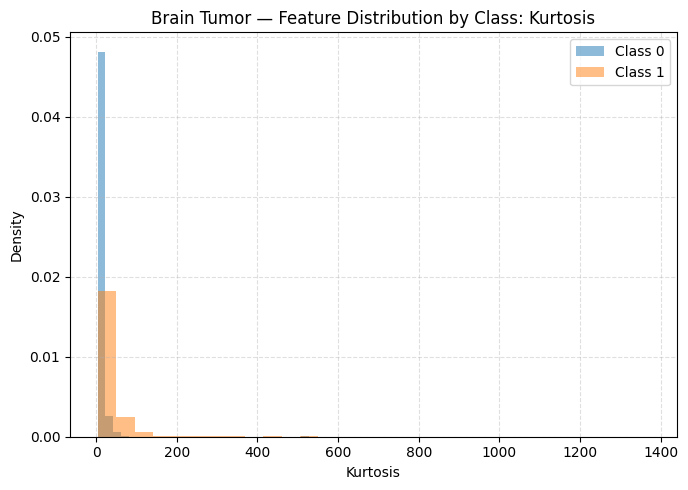

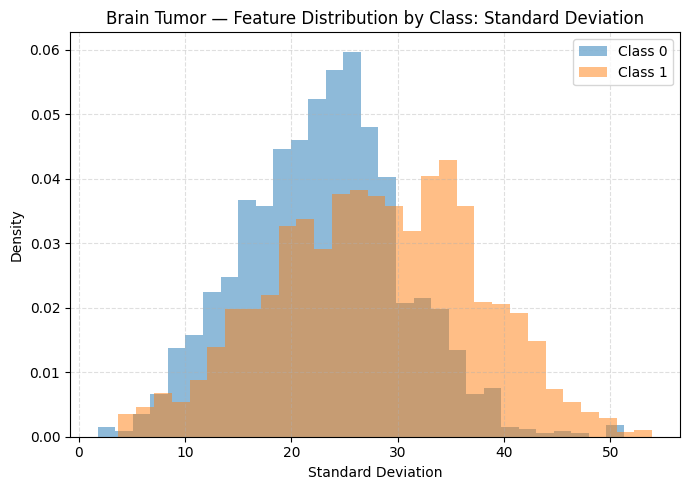

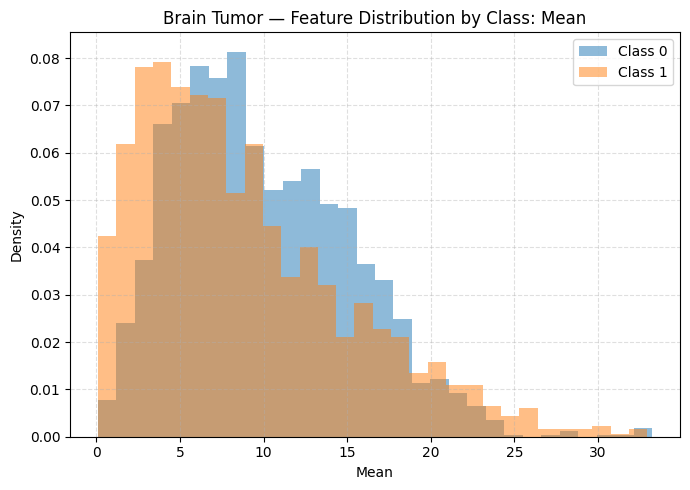

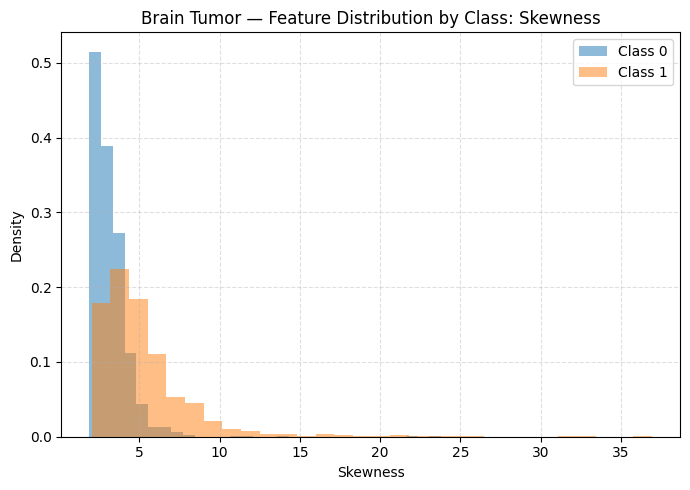

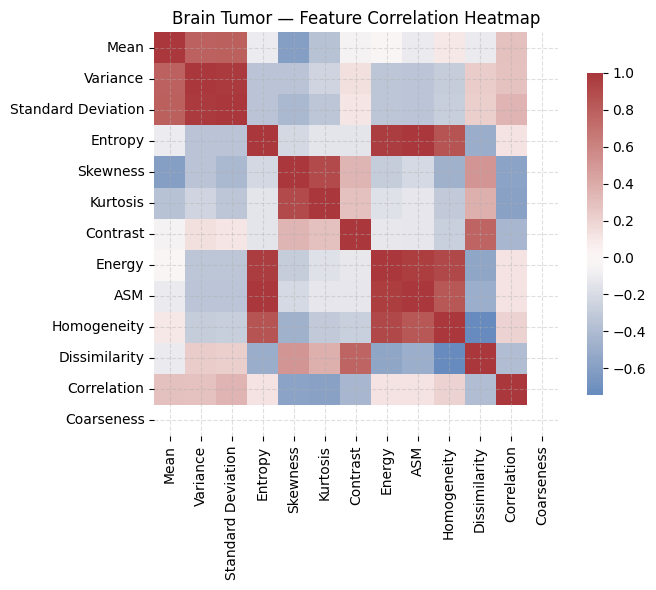

In [5]:
bt_df = pd.concat([X_bt.copy(), y_bt.rename("Class")], axis=1)

# Peek at the data
display(bt_df.head(10))           # first 10 rows
display(bt_df.describe().T)       # stats summary

# dtypes summary
print("Dtype counts:\n", bt_df.dtypes.value_counts(), "\n")

# class distribution
cls_counts = bt_df["Class"].value_counts().sort_index()
ax = cls_counts.plot(kind="bar")
ax.set_title("Brain Tumor — Class Distribution")
ax.set_xlabel("Class (0 = no tumor, 1 = tumor)")
ax.set_ylabel("Count")
savefig("brain_class_distribution.png")




# Pick a small feature set to visualize (variance or mutual information)
bt_feats_var = top_features_by_variance(X_bt, k=6)
try:
    bt_feats_mi  = top_features_by_mi(X_bt, y_bt, k=6)
except Exception:
    bt_feats_mi = bt_feats_var

bt_feats = list(dict.fromkeys(bt_feats_var + bt_feats_mi))[:6]  # merge & keep first 6

# Histograms by class
for f in bt_feats:
    plt.figure()
    for c in sorted(bt_df["Class"].unique()):
        subset = bt_df.loc[bt_df["Class"]==c, f].values
        plt.hist(subset, bins=30, alpha=0.5, label=f"Class {c}", density=True)
    plt.title(f"Brain Tumor — Feature Distribution by Class: {f}")
    plt.xlabel(f)
    plt.ylabel("Density")
    plt.legend()
    savefig(f"brain_hist_{f}.png")

# Correlation heatmap (features only)
plt.figure(figsize=(7.5,6))
corr = X_bt.corr(numeric_only=True)
sns.heatmap(corr, cmap="vlag", center=0, square=True, cbar_kws={"shrink": .8})
plt.title("Brain Tumor — Feature Correlation Heatmap")
savefig("brain_corr_heatmap.png")



# 2.1.2) Breast Cancer

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


Dtype counts:
 float64    30
int64       1
Name: count, dtype: int64 



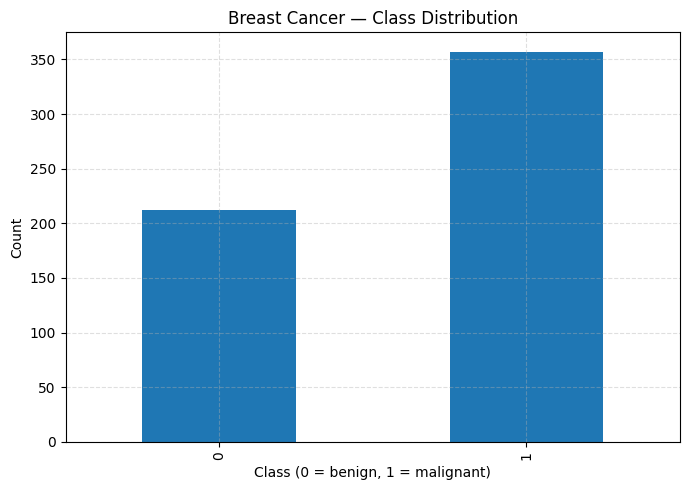

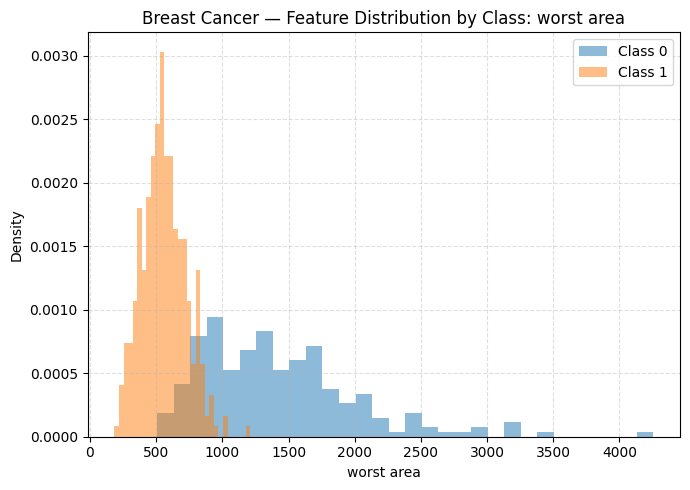

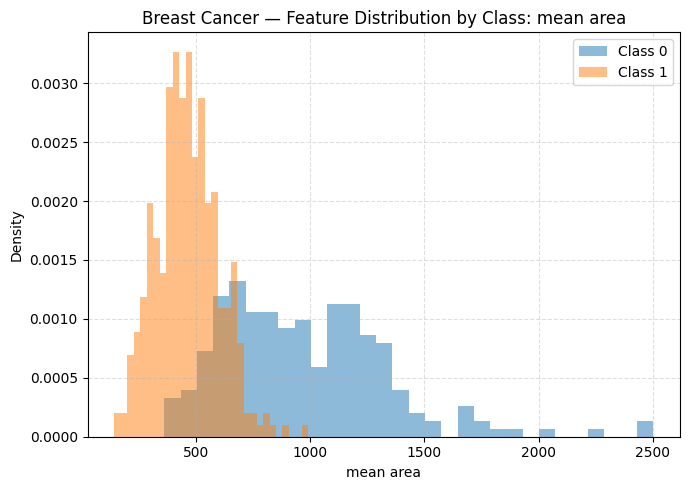

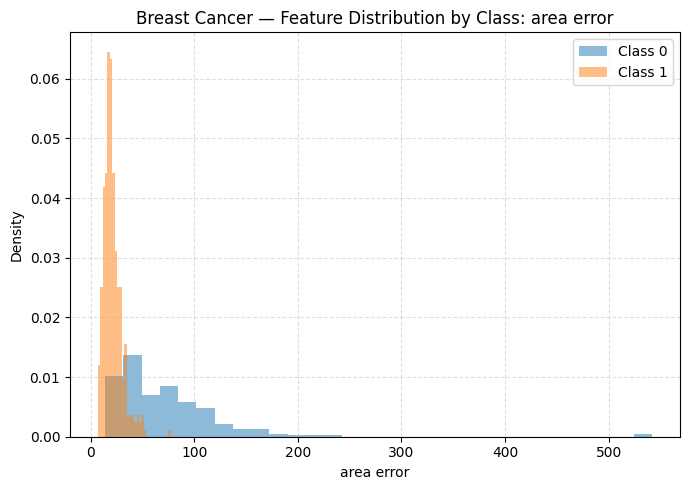

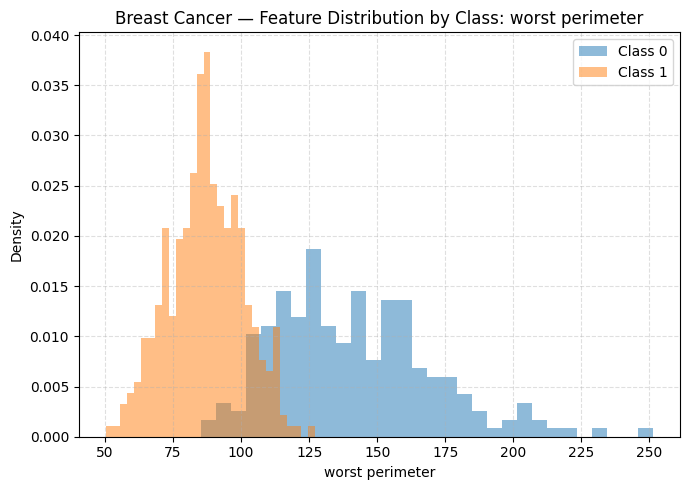

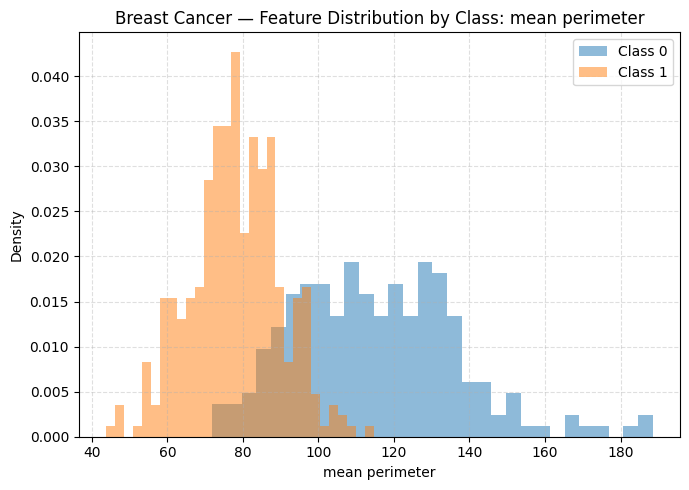

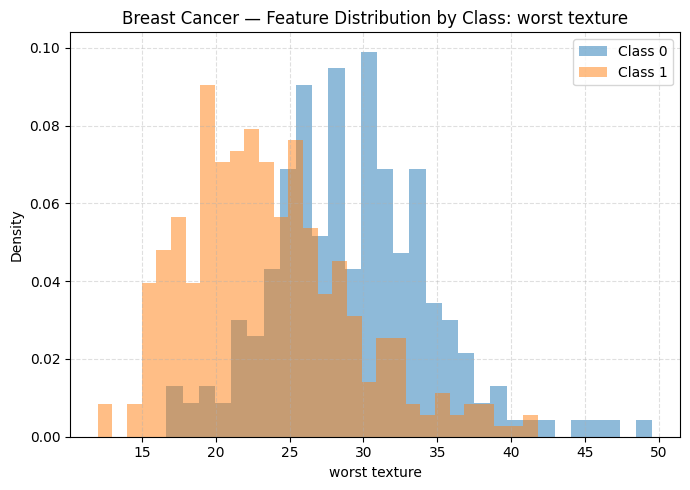

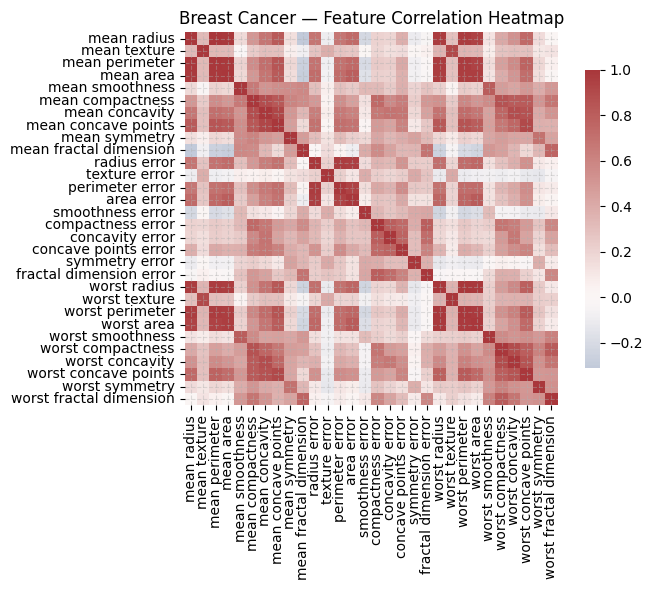

In [6]:
bc_df = pd.concat([X_bc.copy(), y_bc.rename("Class")], axis=1)

# Peek at the data
display(bc_df.head(10))
display(bc_df.describe().T)

# dtypes summary
print("Dtype counts:\n", bc_df.dtypes.value_counts(), "\n")

# class distribution
cls_counts = bc_df["Class"].value_counts().sort_index()
ax = cls_counts.plot(kind="bar")
ax.set_title("Breast Cancer — Class Distribution")
ax.set_xlabel("Class (0 = benign, 1 = malignant)")
ax.set_ylabel("Count")
savefig("breast_class_distribution.png")




# Select features to visualize
bc_feats_var = top_features_by_variance(X_bc, k=6)
try:
    bc_feats_mi  = top_features_by_mi(X_bc, y_bc, k=6)
except Exception:
    bc_feats_mi = bc_feats_var

bc_feats = list(dict.fromkeys(bc_feats_var + bc_feats_mi))[:6]

# Histograms by class
for f in bc_feats:
    plt.figure()
    for c in sorted(bc_df["Class"].unique()):
        subset = bc_df.loc[bc_df["Class"]==c, f].values
        plt.hist(subset, bins=30, alpha=0.5, label=f"Class {c}", density=True)
    plt.title(f"Breast Cancer — Feature Distribution by Class: {f}")
    plt.xlabel(f)
    plt.ylabel("Density")
    plt.legend()
    savefig(f"breast_hist_{f}.png")

# Correlation heatmap
plt.figure(figsize=(7.5,6))
corr = X_bc.corr(numeric_only=True)
sns.heatmap(corr, cmap="vlag", center=0, square=True, cbar_kws={"shrink": .8})
plt.title("Breast Cancer — Feature Correlation Heatmap")
savefig("breast_corr_heatmap.png")


## 3) Train/Test Split

In [7]:
from sklearn.model_selection import train_test_split


def prep_split(X, y, test_size=0.2, seed=RANDOM_STATE):
    # Stratify preserves label ratios in train vs test
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)

X_bt_tr, X_bt_te, y_bt_tr, y_bt_te = prep_split(X_bt, y_bt)
X_bc_tr, X_bc_te, y_bc_tr, y_bc_te = prep_split(X_bc, y_bc)

print('BT train/test:', X_bt_tr.shape, X_bt_te.shape)
print('BC train/test:', X_bc_tr.shape, X_bc_te.shape)

BT train/test: (3009, 13) (753, 13)
BC train/test: (455, 30) (114, 30)


## 4) Models & Hyperparameter Grids (8 total)
We’ll use GridSearchCV (StratifiedKFold=5) and ROC-AUC as the performance metric.

In [8]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

#A dictionary models_grids with 7 Machine Learning Methods
#Pipeline chain pre-processing and the model together
#StandardScaler to standardize features -> especially important for distance-based algorithms

models_grids = {
    'LogReg': (
        Pipeline([('scaler', StandardScaler()),
                  ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))]),
        {'clf__C':[0.1,1,10]}
    ),
    'SVM-Linear': (
        Pipeline([('scaler', StandardScaler()),
                  ('clf', SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_STATE))]),
        {'clf__C':[0.1,1,10]}
    ),
    'SVM-RBF': (
        Pipeline([('scaler', StandardScaler()),
                  ('clf', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE))]),
        {'clf__C':[0.5,1,5], 'clf__gamma':['scale','auto']}
    ),
    'kNN': (
        Pipeline([('scaler', StandardScaler()),
                  ('clf', KNeighborsClassifier())]),
        {'clf__n_neighbors':[3,5,7,9]}
    ),
    'DecisionTree': (
        DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=RANDOM_STATE),
        {'max_depth':[None,3,5,7], 'min_samples_leaf':[1,3,5]}
    ),
    'RandomForest': (
        RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
        {'max_depth':[None,5,10], 'min_samples_leaf':[1,3,5]}
    ),
    'GradientBoosting': (
        GradientBoostingClassifier(random_state=RANDOM_STATE),
        {'learning_rate':[0.05,0.1], 'n_estimators':[150,250], 'max_depth':[2,3]}
    ),
    #Multilayer Perceptron
    'MLP': (
        Pipeline([('scaler', StandardScaler()), ('clf', None)]),
        {}
    )
}

def cv_fit_best(name, estimator, param_grid, Xtr, ytr):
    # Training set is split into 5 folds.
    # StratifiedKFold ensures each fold has the same class balance as the whole dataset.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    # Define a dictionary of cadidate values for each hyperparameter
    # Tries every combination
    # Utilizes ROC_AUC as performance metric. Measures how well the model ranks positive cases above negative cases.
    # Refit=true retrains a fresh model on the entire training set using the best hyperparameters
    gs = GridSearchCV(estimator, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, refit=True)
    gs.fit(Xtr, ytr)
    return gs.best_estimator_, gs.best_score_, gs.best_params_

def evaluate_on_test(model, Xte, yte):
    y_pred = model.predict(Xte)
    try:
        y_proba = model.predict_proba(Xte)[:,1]
    except Exception:
        dec = model.decision_function(Xte)
        y_proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)
    metrics = {
        'accuracy': accuracy_score(yte, y_pred),
        'precision': precision_score(yte, y_pred, zero_division=0),
        'recall': recall_score(yte, y_pred, zero_division=0),
        'f1': f1_score(yte, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(yte, y_proba),
    }
    return metrics, y_pred, y_proba


## 5) Keras MLP (shallow DL)
Feedforward network to complete the 8 algorithms.

In [9]:
# Default number of neurons in the hidden layers = 64
# Dropout rate to reduce overfitting = 10%
def build_mlp(input_dim, hidden=64, dropout=0.1):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    #Sigmoid activation function so output is between 0 and 1
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def run_mlp(Xtr, ytr, Xte, yte, epochs=40, batch=32):
    # Build MLP
    mlp = build_mlp(Xtr.shape[1])
    # Standardize trainning and test data
    scaler = StandardScaler().fit(Xtr)
    Xtr_s = scaler.transform(Xtr)
    Xte_s = scaler.transform(Xte)
    # If model does not improve for 5 epochs, model stops early
    es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
    hist = mlp.fit(Xtr_s, ytr, validation_split=0.2, epochs=epochs, batch_size=batch, verbose=0, callbacks=[es])
    y_proba = mlp.predict(Xte_s, verbose=0).ravel()
    y_pred = (y_proba >= 0.5).astype(int)
    metrics = {
        'accuracy': accuracy_score(yte, y_pred),
        'precision': precision_score(yte, y_pred, zero_division=0),
        'recall': recall_score(yte, y_pred, zero_division=0),
        'f1': f1_score(yte, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(yte, y_proba),
    }
    return mlp, scaler, hist.history, metrics, y_pred, y_proba


## 6) Run Experiment Suite on Both Datasets
Trains/tunes classical models with CV, runs MLP, collects results, and prints comparison tables.

In [10]:
def run_suite(dataset_name, Xtr, ytr, Xte, yte):
    rows = []
    fitted = {}
    for name, (est, grid) in models_grids.items():
        if name != 'MLP':
            best_model, cv_auc, best_params = cv_fit_best(name, est, grid, Xtr, ytr)
            test_metrics, y_pred, y_proba = evaluate_on_test(best_model, Xte, yte)
            rows.append({'Dataset': dataset_name, 'Model': name, 'CV_ROC_AUC': cv_auc, **test_metrics, 'BestParams': best_params})
            fitted[name] = {'model': best_model, 'y_pred': y_pred, 'y_proba': y_proba}
        else:
            mlp, scaler, history, test_metrics, y_pred, y_proba = run_mlp(Xtr, ytr, Xte, yte)
            rows.append({'Dataset': dataset_name, 'Model': 'MLP', 'CV_ROC_AUC': np.nan, **test_metrics, 'BestParams': {'hidden':64,'dropout':0.1}})
            fitted['MLP'] = {'model': mlp, 'scaler': scaler, 'history': history, 'y_pred': y_pred, 'y_proba': y_proba}
    df = pd.DataFrame(rows).sort_values(['Dataset','roc_auc'], ascending=[True,False]).reset_index(drop=True)
    return df, fitted

bt_results, bt_fitted = run_suite('BrainTumor', X_bt_tr, y_bt_tr, X_bt_te, y_bt_te)
bc_results, bc_fitted = run_suite('BreastCancer', X_bc_tr, y_bc_tr, X_bc_te, y_bc_te)

print('Brain Tumor results:')
display(bt_results)
print('\nBreast Cancer results:')
display(bc_results)

Brain Tumor results:


,Dataset,Model,CV_ROC_AUC,accuracy,precision,recall,f1,roc_auc,BestParams
0,BrainTumor,MLP,NaN,0.990704,0.994012,0.985163,0.989568,0.999593,"{'hidden': 64, 'dropout': 0.1}"
1,BrainTumor,SVM-Linear,0.997477,0.990704,0.991071,0.988131,0.989599,0.999522,{'clf__C': 10}
2,BrainTumor,LogReg,0.998172,0.992032,0.991098,0.991098,0.991098,0.999515,{'clf__C': 10}
3,BrainTumor,GradientBoosting,0.998619,0.992032,1.000000,0.982196,0.991018,0.998630,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
4,BrainTumor,SVM-RBF,0.997971,0.992032,0.994030,0.988131,0.991071,0.998509,"{'clf__C': 5, 'clf__gamma': 'scale'}"
5,BrainTumor,RandomForest,0.997659,0.993360,1.000000,0.985163,0.992526,0.997104,"{'max_depth': None, 'min_samples_leaf': 1}"
6,BrainTumor,kNN,0.995514,0.984064,0.993921,0.970326,0.981982,0.996287,{'clf__n_neighbors': 9}
7,BrainTumor,DecisionTree,0.991136,0.992032,0.996997,0.985163,0.991045,0.990427,"{'max_depth': 7, 'min_samples_leaf': 5}"



Breast Cancer results:


,Dataset,Model,CV_ROC_AUC,accuracy,precision,recall,f1,roc_auc,BestParams
0,BreastCancer,LogReg,0.995769,0.956140,0.985507,0.944444,0.964539,0.995370,{'clf__C': 1}
1,BreastCancer,kNN,0.989938,0.973684,0.960000,1.000000,0.979592,0.994378,{'clf__n_neighbors': 9}
2,BreastCancer,SVM-Linear,0.995666,0.964912,0.985714,0.958333,0.971831,0.994048,{'clf__C': 0.1}
3,BreastCancer,SVM-RBF,0.996285,0.964912,0.985714,0.958333,0.971831,0.994048,"{'clf__C': 1, 'clf__gamma': 'scale'}"
4,BreastCancer,RandomForest,0.992415,0.947368,0.958333,0.958333,0.958333,0.993717,"{'max_depth': None, 'min_samples_leaf': 1}"
5,BreastCancer,MLP,NaN,0.964912,0.985714,0.958333,0.971831,0.993717,"{'hidden': 64, 'dropout': 0.1}"
6,BreastCancer,GradientBoosting,0.993189,0.956140,0.946667,0.986111,0.965986,0.991402,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
7,BreastCancer,DecisionTree,0.955573,0.903509,0.955224,0.888889,0.920863,0.928571,"{'max_depth': 3, 'min_samples_leaf': 5}"


Saved: BT_model_comparison_F1.png


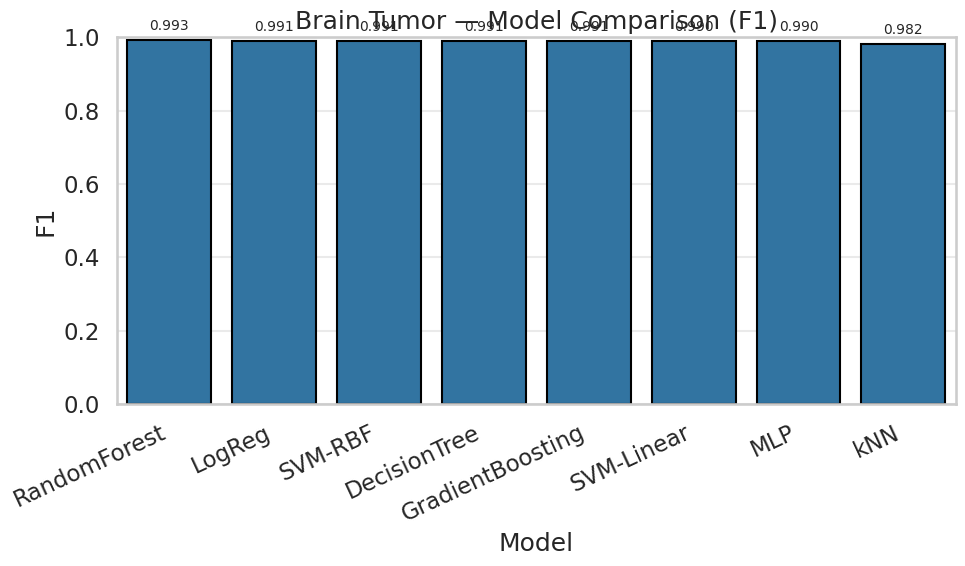

Saved: BC_model_comparison_F1.png


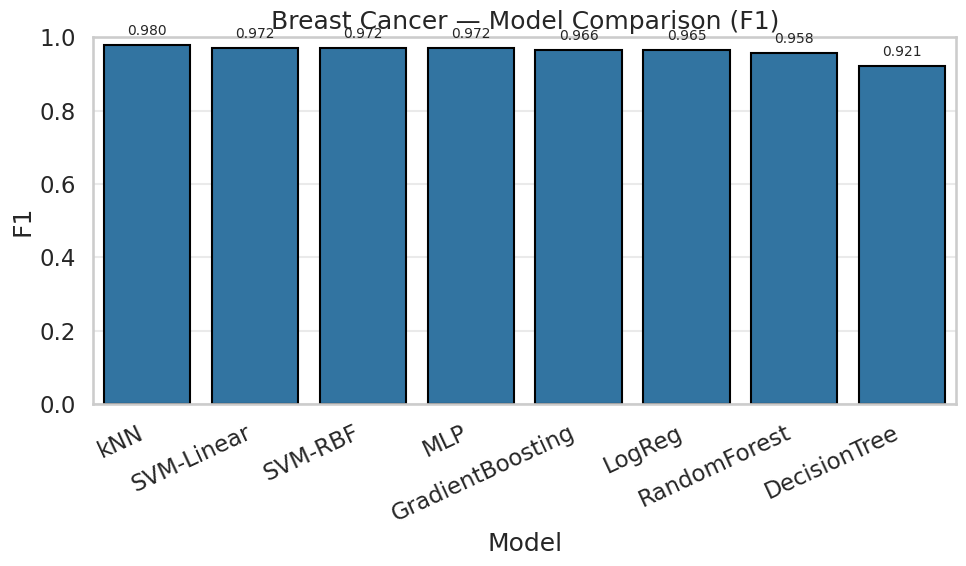

Saved: BT_model_comparison_AUC.png


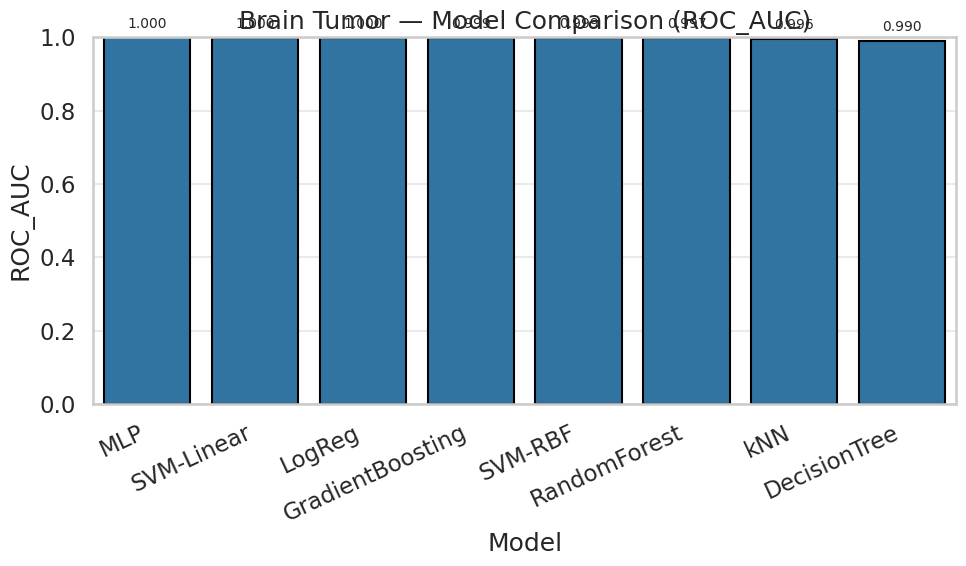

Saved: BC_model_comparison_AUC.png


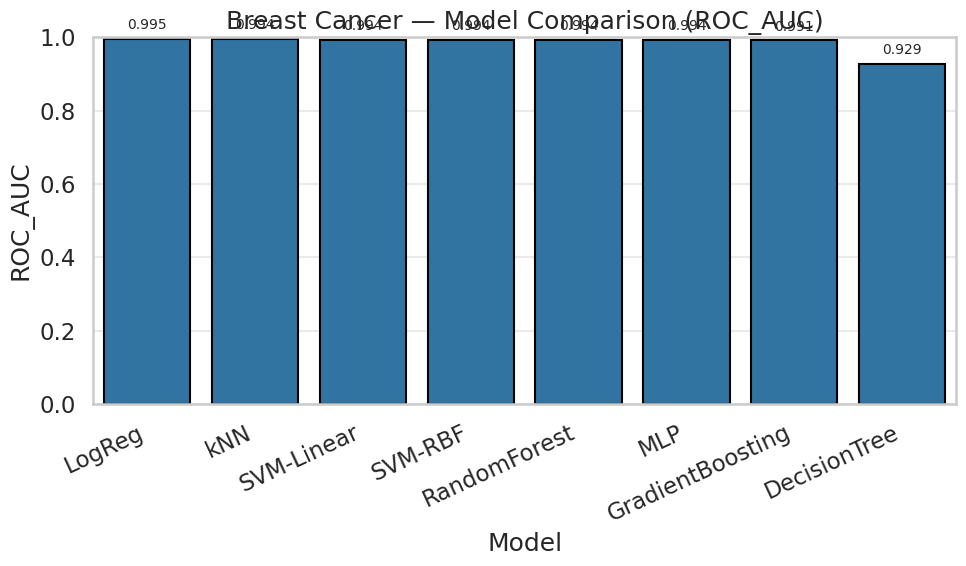

Saved: Grouped_model_comparison_F1.png


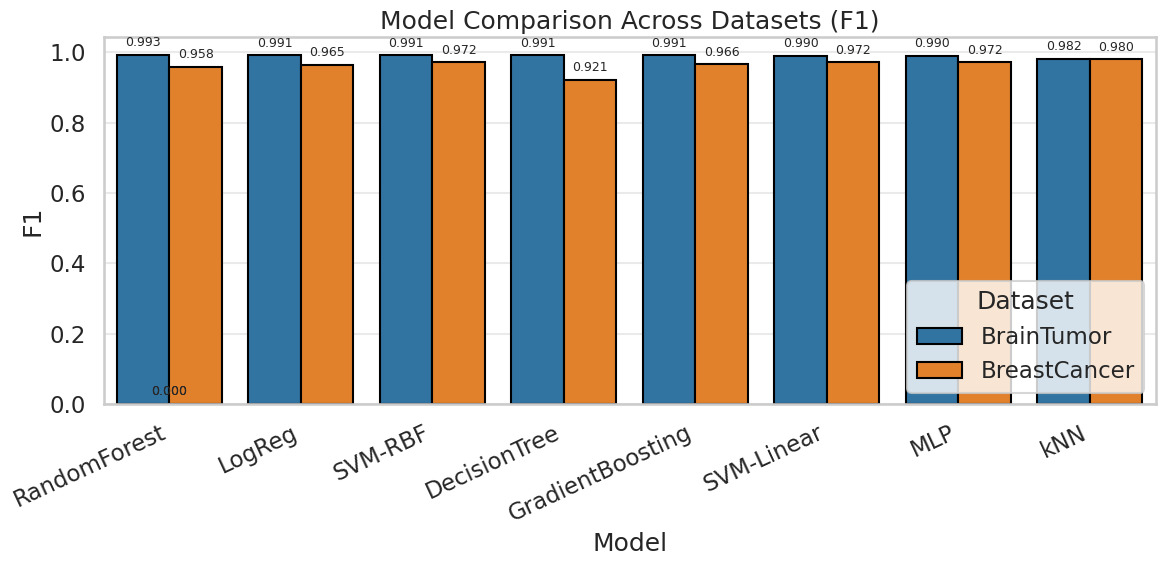

Saved: Grouped_model_comparison_AUC.png


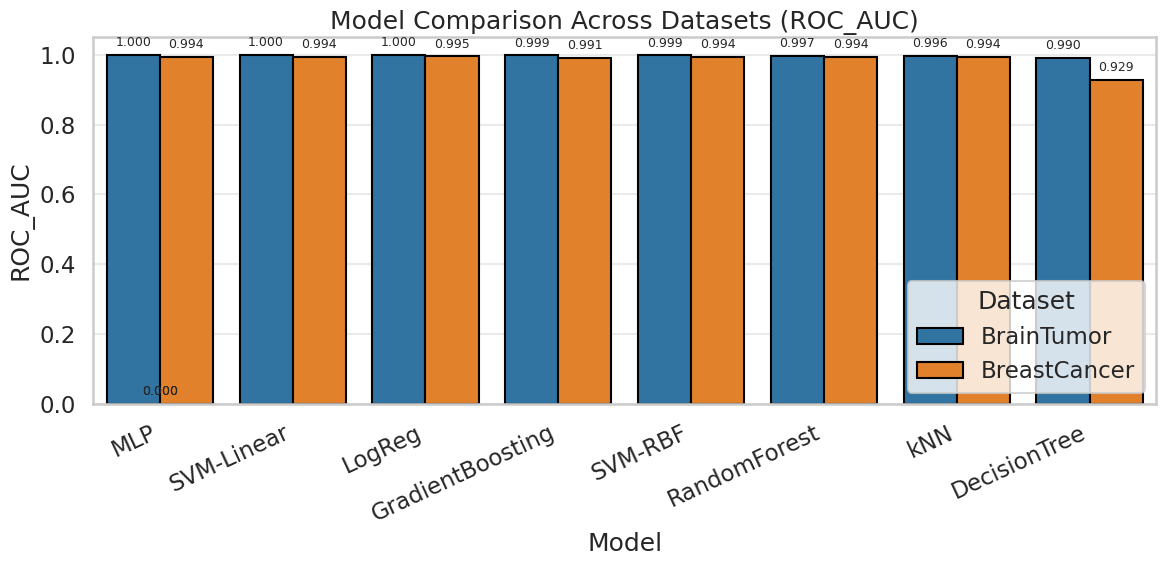

In [11]:
# --- Install/Imports (seaborn is optional but makes clean bars) ---
# If seaborn isn't installed in your Colab runtime, uncomment:
# !pip install seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["savefig.dpi"] = 300

# ---------- Helpers ----------
def _save(fig, fname):
    fig.tight_layout()
    fig.savefig(fname, bbox_inches="tight")
    print(f"Saved: {fname}")

def _prep_single(df, dataset, metric):
    d = df.copy()
    d = d.sort_values(metric, ascending=False)
    return d

def barplot_single(results_df, dataset_name, metric="f1", filename=None, ylim=None, decimals=3):
    """
    Make a bar plot for one dataset, one metric (e.g., f1 or roc_auc).
    """
    d = _prep_single(results_df, dataset_name, metric)
    fig, ax = plt.subplots()
    ax = sns.barplot(data=d, x="Model", y=metric, color="C0", edgecolor="black")
    ax.set_title(f"{dataset_name} — Model Comparison ({metric.upper()})")
    ax.set_xlabel("Model")
    ax.set_ylabel(metric.upper())
    ax.set_ylim(0 if ylim is None else ylim[0], 1 if ylim is None else ylim[1])
    # Annotate bars
    for p in ax.patches:
        val = p.get_height()
        ax.annotate(f"{val:.{decimals}f}", (p.get_x() + p.get_width()/2, val),
                    ha="center", va="bottom", fontsize=10, xytext=(0,5), textcoords="offset points")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    if filename:
        _save(fig, filename)
    plt.show()

def barplot_grouped(bt_df, bc_df, metric="f1", filename=None, decimals=3):
    """
    Grouped bars (BrainTumor vs BreastCancer) per model for one metric.
    Assumes both tables contain the same set of models (order will follow BrainTumor).
    """
    a = bt_df[["Model", metric]].copy()
    a["Dataset"] = "BrainTumor"
    b = bc_df[["Model", metric]].copy()
    b["Dataset"] = "BreastCancer"
    g = pd.concat([a, b], ignore_index=True)

    # Keep a consistent model order based on BrainTumor ranking
    order = bt_df.sort_values(metric, ascending=False)["Model"].tolist()
    fig, ax = plt.subplots(figsize=(12,6))
    ax = sns.barplot(data=g, x="Model", y=metric, hue="Dataset", order=order, edgecolor="black")
    ax.set_title(f"Model Comparison Across Datasets ({metric.upper()})")
    ax.set_xlabel("Model")
    ax.set_ylabel(metric.upper())
    # Annotate bars
    for p in ax.patches:
        val = p.get_height()
        ax.annotate(f"{val:.{decimals}f}", (p.get_x() + p.get_width()/2, val),
                    ha="center", va="bottom", fontsize=9, xytext=(0,4), textcoords="offset points")
    plt.xticks(rotation=25, ha="right")
    plt.legend(title="Dataset")
    plt.tight_layout()
    if filename:
        _save(fig, filename)
    plt.show()

# ---------- Make the plots ----------
# Ensure the expected columns exist:
assert {"Model","f1","roc_auc"}.issubset(bt_results.columns)
assert {"Model","f1","roc_auc"}.issubset(bc_results.columns)

# 1) Single-dataset bars (F1)
barplot_single(bt_results, "Brain Tumor", metric="f1", filename="BT_model_comparison_F1.png")
barplot_single(bc_results, "Breast Cancer", metric="f1", filename="BC_model_comparison_F1.png")

# 2) Single-dataset bars (ROC-AUC)
barplot_single(bt_results, "Brain Tumor", metric="roc_auc", filename="BT_model_comparison_AUC.png")
barplot_single(bc_results, "Breast Cancer", metric="roc_auc", filename="BC_model_comparison_AUC.png")

# 3) Grouped bars across datasets (same metric)
barplot_grouped(bt_results, bc_results, metric="f1", filename="Grouped_model_comparison_F1.png")
barplot_grouped(bt_results, bc_results, metric="roc_auc", filename="Grouped_model_comparison_AUC.png")


## 7) Plots — Best Model per Dataset
Confusion Matrix and ROC Curve using the recorded predictions.

Best model name= MLP


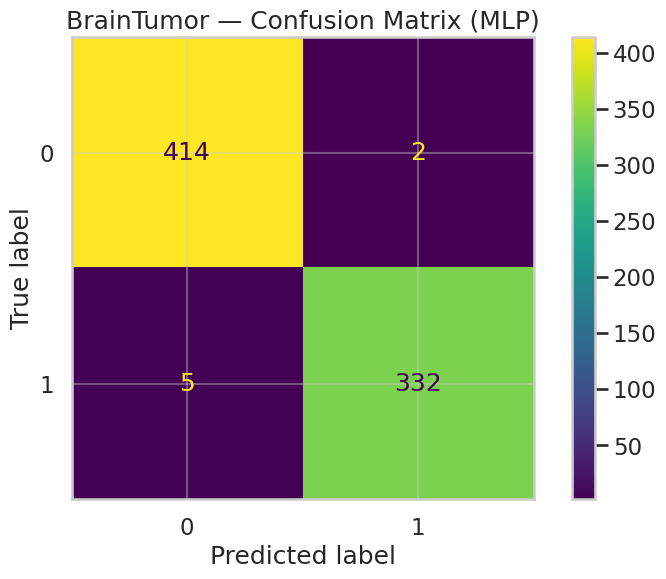

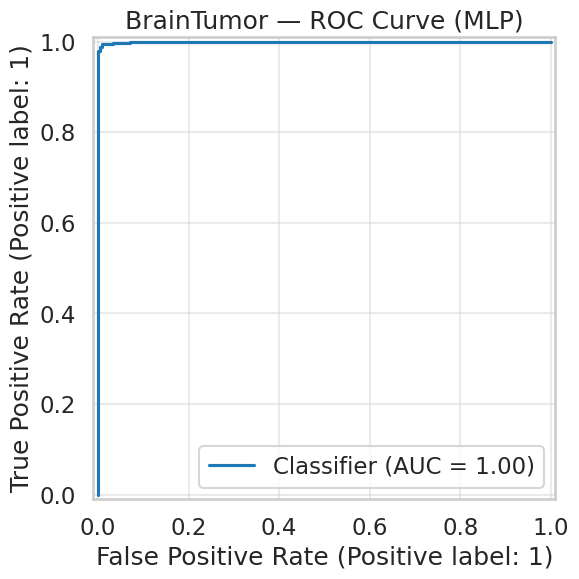

Best model name= LogReg


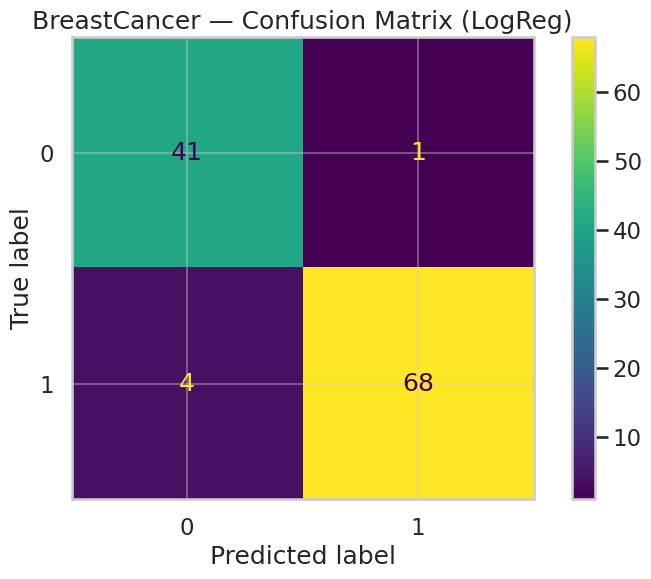

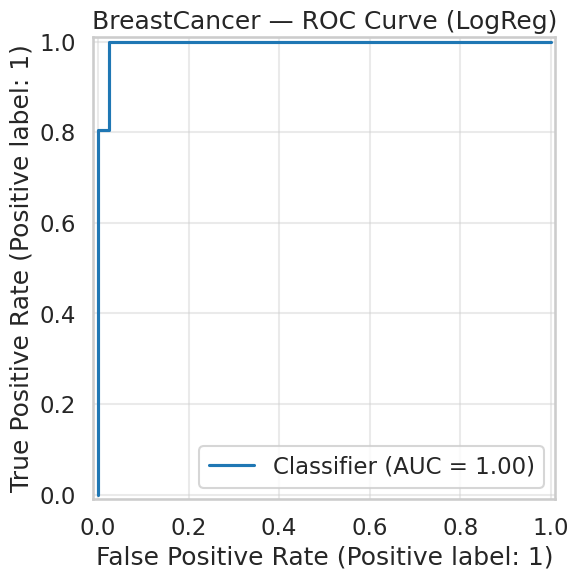

In [13]:
def best_by_auc(results_df):
    # Drop rows where roc_auc is NaN
    valid_df = results_df.dropna(subset=["roc_auc"])
    if valid_df.empty:
        return None  # or raise an Exception if you prefer
    return valid_df.loc[valid_df['roc_auc'].idxmax(), 'Model']

def plot_test_curves(dataset_name, results_df, fitted, Xte, yte):
    best_model_name = best_by_auc(results_df)
    print(f'Best model name= {best_model_name}')
    y_pred = fitted[best_model_name]['y_pred']
    y_proba = fitted[best_model_name]['y_proba']

    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_predictions(yte, y_pred)
    plt.title(f"{dataset_name} — Confusion Matrix ({best_model_name})")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_predictions(yte, y_proba)
    plt.title(f"{dataset_name} — ROC Curve ({best_model_name})")
    plt.show()

plot_test_curves('BrainTumor', bt_results, bt_fitted, X_bt_te, y_bt_te)
plot_test_curves('BreastCancer', bc_results, bc_fitted, X_bc_te, y_bc_te)